In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
%matplotlib inline

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.rename(columns = {'#stream':'stream'}, inplace = True) # we rename first column to ease access 
data = data.dropna()
print(data.shape)
data.head()

(534953, 6)


,stream,isp,browser,connected,p2p,cdn
0,1,Fro,Iron,True,195910.840977,109025.960619
1,1,Fro,EarthWolf,True,186711.522041,113744.856814
2,1,Arange,Iron,True,189428.293434,115944.246844
3,1,Arange,Iron,True,0.000000,307577.191067
4,1,BTP,EarthWolf,True,207246.640473,107010.608093


# Helper functions

In [5]:
def make_dataframe(data, isp_brw_name, col_name, rate, reduc=1e9):
    ungrouped_df = data.loc[(data.isp == isp_brw_name) | (data.browser == isp_brw_name) ].copy()
    ungrouped_df['rate'] = ungrouped_df['p2p'] * 100 / (ungrouped_df['p2p'] + ungrouped_df['cdn']) 
    ungrouped_df['good_rate'] = ungrouped_df['rate'] > rate
    ungrouped_df['zero_rate'] = ungrouped_df['rate'] == 0.
    df = (ungrouped_df.groupby(['connected','good_rate','zero_rate',col_name])['p2p', 'cdn'].sum()/reduc).round(2)
    df['p2p_perc'] = (df['p2p'] * 100 / df[['cdn','p2p']].sum(axis=1).sum()).round(2)
    df['cdn_perc'] = (df['cdn'] * 100 / df[['cdn','p2p']].sum(axis=1).sum()).round(2)
    df['p2p_perc_ind'] = (df['p2p'] * 100 / (df[['p2p', 'cdn']].groupby(level=3).sum().sum(axis=1))).round(2)
    df['cdn_perc_ind'] = (df['cdn'] * 100 / (df[['p2p', 'cdn']].groupby(level=3).sum().sum(axis=1))).round(2)
    df['viewer_count'] = ungrouped_df.groupby(['connected','good_rate','zero_rate',col_name])['connected'].count()
    df['viewer_perc'] = (df['viewer_count'] *100 / df['viewer_count'].sum()).round(2)
    return df

In [6]:
def make_stack_list(df, col_name):
    stack_list = []
    for i, sub_df in df.groupby(level=(0,1,2)):
        s_df = pd.DataFrame(index=df.index.levels[3])
        s_df[col_name] = 0.
        sub_df = sub_df.reset_index(level=(0,1,2), drop=True)[col_name]
        stack_list.append(pd.concat([s_df,sub_df], ignore_index=True, axis=1).fillna(0.)[1].tolist())
    return stack_list

def bar_stack(stacks, bar_names, stacks_names, title, y_label):
    num_stacks = len(stacks)
    num_bars = len(stacks[0])
    width = 0.35
    color = ['#3366CC', '#DC3912','#FF9900','#109618','#990099',
             '#3B3EAC','#0099C6','#DD4477','#66AA00','#B82E2E','#316395',
             '#994499','#22AA99','#AAAA11','#6633CC','#E67300','#8B0707','#329262','#5574A6','#3B3EAC']

    fig, ax = plt.subplots(figsize=(7.5,5))    
    ind = np.arange(num_bars)
    bottom = [0 for i in range(num_bars)]
    for st in range(num_stacks):
        ax.bar(ind+width/2, stacks[st], width, bottom=bottom, color=color[st], label=stacks_names[st])
        bottom = [bot + st for bot, st in zip(bottom, stacks[st])]

    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=15, y=1.05)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(bar_names)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

def bar_stack_sub(ax, stacks, bar_names, stacks_names, title, y_label):
    num_stacks = len(stacks)
    num_bars = len(stacks[0])
    width = 0.35
    color = ['#3366CC', '#DC3912','#FF9900','#109618','#990099',
             '#3B3EAC','#0099C6','#DD4477','#66AA00','#B82E2E','#316395',
             '#994499','#22AA99','#AAAA11','#6633CC','#E67300','#8B0707','#329262','#5574A6','#3B3EAC']

    ind = np.arange(num_bars)
    bottom = [0 for i in range(num_bars)]
    for st in range(num_stacks):
        ax.bar(ind+width/2, stacks[st], width, bottom=bottom,color=color[st], label=stacks_names[st])
        bottom = [bot + st for bot, st in zip(bottom, stacks[st])]

    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(bar_names)

def make_p2p_cdn_plot(df, isp_name, index, col_name1, col_name2, title):
    stacks1 = make_stack_list(df, col_name1)
    stacks2 = make_stack_list(df, col_name2)
    bar_names =  df.index.levels[3]
    stacks_names = [r'OFF', r'ON w/ $\frac{p2p}{cdn} < 0.6$',
                    r'ON w/ $\frac{p2p}{cdn} = 0.0$', r'ON w/ $\frac{p2p}{cdn} > 0.6$']
    y_label = '%'
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey=False)
    fig.suptitle(title, fontsize=15, y=1.05)
    bar_stack_sub(ax1, stacks1, bar_names, stacks_names, title='% from cdn', y_label=y_label)
    bar_stack_sub(ax2, stacks2, bar_names, stacks_names, title='% from p2p', y_label=y_label)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## FIRST CHECKS

First I wanted to check basic information about ISPs: check how many percent of their downloads come from p2p and cdn and check how many people are connected to the backend.
 
The columns p2p_perc and cdn_perc respectively represent the contribution of p2p and cdn in % of the total amount of data downloaded by one isp. For Arange for instance, p2p downloads represent 1.25% of the total amount of data downloaded by Arange viewers...  

We will also consider through this notebook that **ON** and **OFF** repectively refer to **'connected to the backend'** and **'not connected to the backend'**

In [7]:
col_traffic = data.groupby(['isp','connected'])['p2p', 'cdn'].sum()/1e9
col_traffic['p2p_perc'] = col_traffic['p2p'] * 100 / col_traffic.groupby(level=0).sum()[['cdn', 'p2p']].sum(axis=1)
col_traffic['cdn_perc'] = col_traffic['cdn'] * 100 / col_traffic.groupby(level=0).sum()[['cdn', 'p2p']].sum(axis=1)
col_traffic['viewer_count'] = data.groupby(['isp', 'connected'])['connected'].agg(['count'])['count']
col_traffic['viewer_perc'] = col_traffic['viewer_count'].groupby(level=0).apply(lambda x: x*100/x.sum())
col_traffic.round(2)

p2p      cdn  p2p_perc  cdn_perc  viewer_count  \
isp           connected                                                       
Arange        False         0.00    30.19      0.00      0.92          1641   
              True         40.96  3200.53      1.25     97.83        163700   
BTP           False         0.00     4.53      0.00      0.11           138   
              True       1794.00  2172.00     45.18     54.70        130178   
Datch Telecam False         0.00   139.94      0.00     78.93         36415   
              True          1.63    35.74      0.92     20.15          9240   
Fro           False         0.00   128.58      0.00      4.94          7524   
              True         56.33  2415.76      2.17     92.89        142265   
Olga          False         0.00     5.58      0.00      7.86          3483   
              True          0.85    64.59      1.20     90.94         40369   

                         viewer_perc  
isp           connected               
Arange        False             0.99  
              True             99.01  
BTP           False             0.11  
              True             99.89  
Datch Telecam False            79.76  
              True             20.24  
Fro           False             5.02  
              True             94.98  
Olga          False             7.94  
              True             92.06

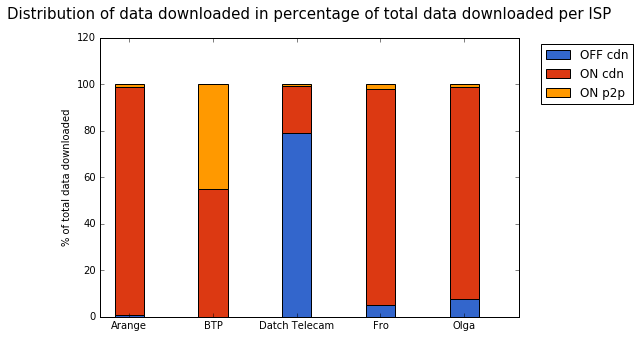

In [8]:
stacks = []
stacks.append(col_traffic.iloc[col_traffic.index.get_level_values('connected') == False]['cdn_perc'].tolist())
stacks.append(col_traffic.iloc[col_traffic.index.get_level_values('connected') == True]['cdn_perc'].tolist())
stacks.append(col_traffic.iloc[col_traffic.index.get_level_values('connected') == True]['p2p_perc'].tolist())

bar_names = col_traffic.index.levels[0]
stacks_names = ['OFF cdn', 'ON cdn', 'ON p2p']
title = 'Distribution of data downloaded in percentage of total data downloaded per ISP'
y_label = '% of total data downloaded'
bar_stack(stacks, bar_names, stacks_names, title, y_label)

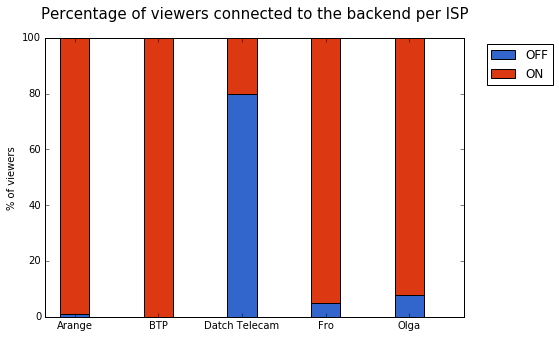

In [9]:
stacks = []
stacks.append(col_traffic.iloc[col_traffic.index.get_level_values('connected') == False]['viewer_perc'].tolist())
stacks.append(col_traffic.iloc[col_traffic.index.get_level_values('connected') == True]['viewer_perc'].tolist())

bar_names =  col_traffic.index.levels[0]
stacks_names = ['OFF', 'ON']
title = 'Percentage of viewers connected to the backend per ISP'
y_label = '% of viewers'
bar_stack(stacks, bar_names, stacks_names, title, y_label)

### Comments
We can note two things:
- All ISP have at least 92% of their viewers connected to the backend **except for Datch Telecam**	that only has 79.76% of its users connected
- All ISP have a very low contribution coming from p2p, at most 2.17% of the total amount of data **except for BTP** that has 45.18% of its downloads coming from p2p.

### Question
We want to understand why p2p contribution is so low although most viewers are connected to the backend.
**However we can already say that Datch Telecam seems to have a connection problem: is it due to a certain type of stream that the viewers are downloading, or due to a certain type of browser, or is this only related to Datch Telecam?**

## P2P/ CDN RATE

My next idea was to compute the p2p/cdn rate of every viewers and have a quick look to what is happening for every isp. Here are the first rows for Arange below.

In [10]:
data_rate = data.copy()
data_rate['rate'] = data_rate['p2p'] * 100 / (data_rate['p2p'] + data_rate['cdn']) 
data_rate['good_rate'] = data_rate['rate'] > 60
data_rate['zero_rate'] = data_rate['rate'] == 0.

data_rate[data.isp == 'Arange'].head()

,stream,isp,browser,connected,p2p,cdn,rate,good_rate,zero_rate
2,1,Arange,Iron,True,189428.293434,115944.246844,62.031869,True,False
3,1,Arange,Iron,True,0.000000,307577.191067,0.000000,False,True
8,1,Arange,EarthWolf,True,217679.617147,94230.141580,69.789294,True,False
11,1,Arange,Iron,True,189400.980615,114280.868906,62.368225,True,False
13,1,Arange,EarthWolf,True,182409.402474,102606.011991,63.999838,True,False


### Comments
I found there are **4 categories of users**:
- some viewers are connected to the backend (ON) and have a rate superior to 60%
- some viewers are connected to the backend (ON) and have a rate inferior to 60%
- some viewers are connected to the backend (ON) and have a rate equals to 0%
- some viewers are not connected to the backend (OFF)

Now my next guess was that a bad rate or a zero rate could be related to a certain stream or a certain browser. I decided to compute the mean rate per stream for the two first categories of viewers (rate superior to 60% and rate inferior to 60%)

In [11]:
means = pd.DataFrame()
good = data_rate.loc[data_rate.good_rate == True].groupby(['isp', 'stream']).mean().rate
bad = data_rate.loc[(data_rate.good_rate == False) & (data_rate.zero_rate == False)].groupby(['isp', 'stream']).mean().rate
means[['good_rate_mean', 'bad_rate_mean']] = pd.concat([good,bad], ignore_index=True, axis=1)

for isp in data['isp'].unique():
    print(isp)
    display(means.round(2).T[isp])

Fro


stream,1,2,3,4,5,6,7,8,9
good_rate_mean,64.98,64.97,65.03,NaN,65.01,64.98,64.98,NaN,65.09
bad_rate_mean,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN


Arange


stream,1,2,3,4,5,6,7,8,9
good_rate_mean,64.98,65.02,65.0,NaN,65.07,65.05,65.04,NaN,65.04
bad_rate_mean,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN


BTP


stream,1,2,3,4,5,6,7,8,9
good_rate_mean,64.98,65.02,64.89,NaN,64.81,64.99,64.99,NaN,64.97
bad_rate_mean,NaN,NaN,NaN,50.06,NaN,NaN,NaN,50.02,NaN


Datch Telecam


stream,1,2,3,4,5,6,7,8,9
good_rate_mean,65.25,64.89,65.05,NaN,65.07,65.1,64.98,NaN,65.15
bad_rate_mean,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN


Olga


stream,1,2,3,4,5,6,7,8,9
good_rate_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.98
bad_rate_mean,10.03,15.0,15.01,0.03,15.01,15.15,14.99,0.03,NaN


### Comments
We can note various things:
- **for every ISP, viewers on stream 8 and 4 have rates inferior to 60%** and they are around 1% except for BTP whose rates for those streams are around 50%
- Arange, BTP, Datch Telecam and Fro have viewers with good rate (superior to 60%) for streams 1,2,3,5,6,7 and 9
- Olga however has viewer with bad rates for those last streams (around 15%) except for stream 9 that has a good rate


Now the issue with measuring these means is that we do not know how people with a good rate for stream 1 contribute to the overall rate of the ISP: maybe stream 1 only represent a very small amount of the data the ISP provided, or maybe there is also a great deal of people with a zero rate on stream 1… So we want to know three things:
- how each stream contributes to the total amount of data an ISP had to deal with
- how each of the four categories of viewers we defined above contribute to the total amount of data an ISP had to deal with
- how each of the four categories of viewers we defined above contribute to each stream

So the next steps consists in doing two things for each ISP:
- **breaking down the total amount of data downloaded per ISP into streams and into categories of users**
- **breaking down the total amount of data downloaded per stream into categories of users**

So in the first case, for each stream we will make % relatively to the total amount of data an ISP had to provide and in the second case we will make % relatively to the each stream.

### Breaking down the total amount of data downloaded per ISP into streams and into categories of users

Here is below a representation of this breaking down process for Arange. The graph on the left represents the % of total downloads coming from the CDN network and the one on the right represent the % of total downloads from p2p network.  


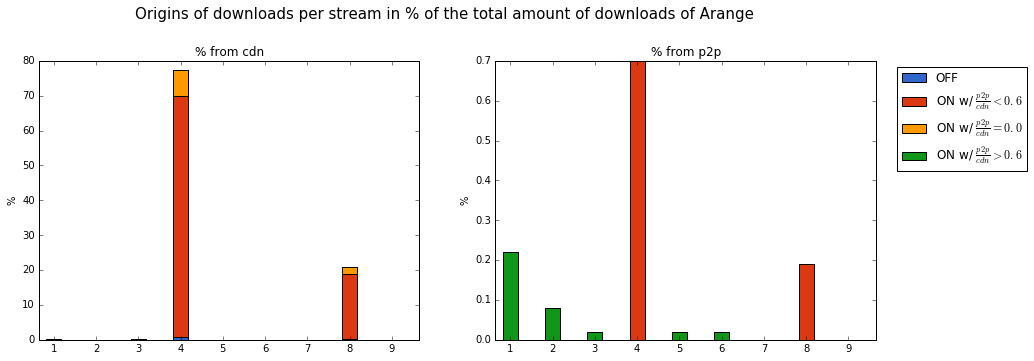

In [12]:
index = 'stream'
isp_name = 'Arange'
arange = make_dataframe(data, isp_name, index, 60)
title = 'Origins of downloads per stream in % of the total amount of downloads of {}'.format(isp_name)
make_p2p_cdn_plot(arange, isp_name, index, 'cdn_perc', 'p2p_perc', title)

First thing that we can see is that streams 4 and 8 seem to be the most important in terms of downloads: almost 100% for Arange. Let's see what streams 4 and 8 represent for the other ISPs:

In [13]:
df = (data_rate.groupby(['isp','connected','good_rate','zero_rate','stream'])['p2p', 'cdn'].sum()/1e9).round(2)
df['p2p_perc'] = (df['p2p'] * 100 / (df['cdn'].sum(level=0)+df['p2p'].sum(level=0))).round(2)
df['cdn_perc'] = (df['cdn'] * 100 / (df['cdn'].sum(level=0)+df['p2p'].sum(level=0))).round(2)
df = df.iloc[(df.index.get_level_values('good_rate') == False) & (
               (df.index.get_level_values('stream') == 4) | (df.index.get_level_values('stream') == 8))
              ][['p2p_perc', 'cdn_perc']]
for isp in data['isp'].unique():
    print(isp)
    display(df.T[isp])
    print('% of total amount of data that represent streams 4 and 8: ',round(df.T[isp].sum().sum(),2))
    print('\n')

Fro


connected False        True                    
good_rate False        False                   
zero_rate True         False        True       
stream        4     8      4      8     4     8
p2p_perc   0.00  0.00   1.25   0.45  0.00  0.00
cdn_perc   3.61  1.28  61.23  22.20  6.39  2.51

% of total amount of data that represent streams 4 and 8:  98.92


Arange


connected False        True                    
good_rate False        False                   
zero_rate True         False        True       
stream        4     8      4      8     4     8
p2p_perc   0.00  0.00   0.70   0.19  0.00  0.00
cdn_perc   0.74  0.18  69.28  18.81  7.28  1.92

% of total amount of data that represent streams 4 and 8:  99.1


BTP


connected False      True                    
good_rate False      False                   
zero_rate True       False        True       
stream        4    8     4      8     4     8
p2p_perc   0.00  0.0  5.38  39.59  0.00  0.00
cdn_perc   0.02  0.1  5.38  39.62  1.06  8.39

% of total amount of data that represent streams 4 and 8:  99.54


Datch Telecam


connected  False        True                    
good_rate  False        False                   
zero_rate  True         False        True       
stream         4      8     4      8     4     8
p2p_perc    0.00   0.00  0.15   0.22   0.0  0.00
cdn_perc   29.27  45.94  7.46  10.78   0.5  1.02

% of total amount of data that represent streams 4 and 8:  95.34


Olga


connected False       True                    
good_rate False       False                   
zero_rate True        False        True       
stream        4    8      4      8     4     8
p2p_perc   0.00  0.0   0.01   0.01  0.00  0.00
cdn_perc   2.67  4.4  31.96  43.03  3.12  4.91

% of total amount of data that represent streams 4 and 8:  90.11




### COMMENTS
We can note various things:
- for every ISP, streams **8 and 4 represent at least 90% of the total amount of data downloaded**
- Arange, Fro and Olga have respectively 80%, 80% and 75% of their total amount of data coming from viewers of stream 4 and 8 that has a bad rate 
- Datch Telecam has around 70% of its total amount of data coming from users unconnected to the cdn (OFF) which is a problem that we had already seen at the beginning.
- BTP most important weight is also stream 4 and 8 but as we pointed it out before, BTP has better rates (mean of 50) although they are not up to 60%. So for BTP, 45% of streams 4 and 8 downloads com from cdn and the other 45% come from p2p

### CONCLUSION TO IMPROVE THE SERVICE
**There is a problem with streams 4 and 8: most people downloading these streams have a bad p2p/cdn rate (close to 0% for al ISP except BTP). If we solve this problem we will be highly improving our service to our customers as these streams represent at least 90% of their downloads (close to 99% for Fro, Arange and BTP)**

## Breaking down the total amount of data downloaded per stream into categories of users

Now that we know that the most important weights are streams 4 and 8, let’s have a look to the other streams. So instead of breaking down the total amount of data downloaded per stream, we are going to break down the data downloaded for each stream per category of users.

### Arange, BTP and Fro

These 3 ISPs have a similar situation:

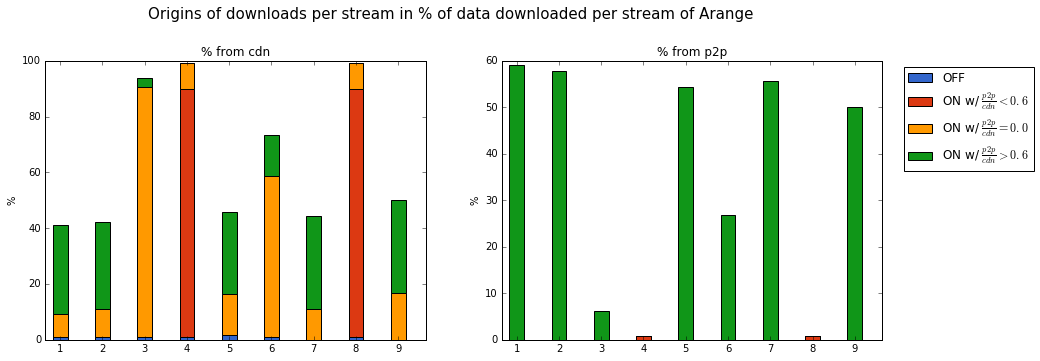

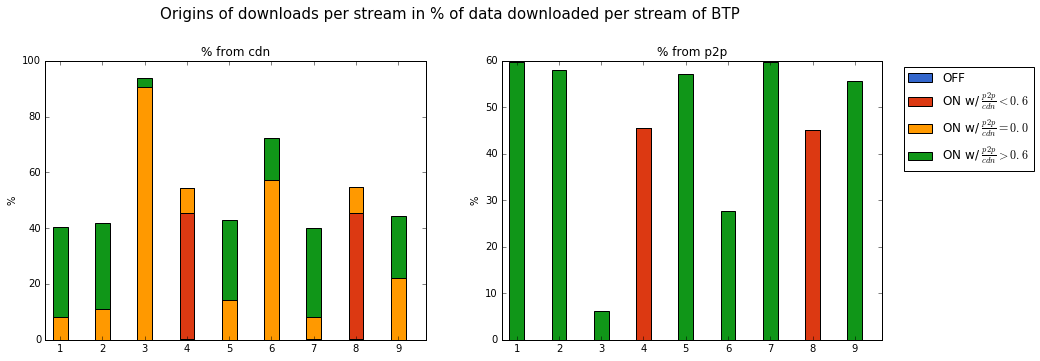

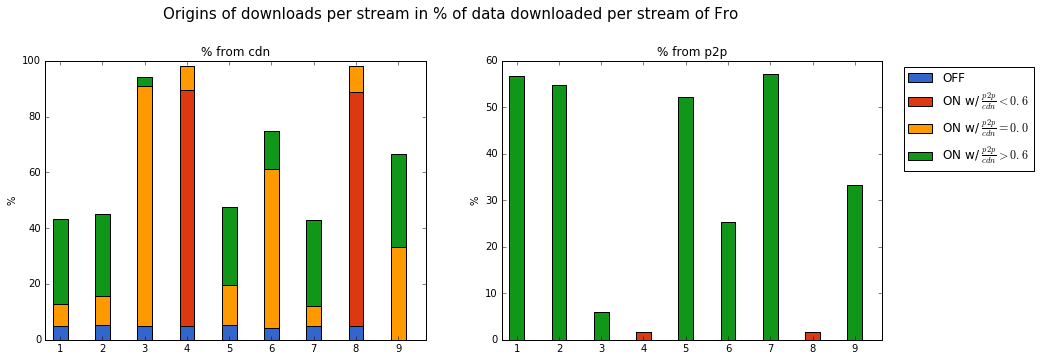

In [14]:
index = 'stream'
isp_name = 'Arange'
arange = make_dataframe(data, isp_name, index, 60)
title = 'Origins of downloads per stream in % of data downloaded per stream of {}'.format(isp_name)
make_p2p_cdn_plot(arange, isp_name, index, 'cdn_perc_ind', 'p2p_perc_ind', title)
isp_name = 'BTP'
btp = make_dataframe(data, isp_name, index, 60)
title = 'Origins of downloads per stream in % of data downloaded per stream of {}'.format(isp_name)
make_p2p_cdn_plot(btp, isp_name, index, 'cdn_perc_ind', 'p2p_perc_ind', title)
isp_name = 'Fro'
fro = make_dataframe(data, isp_name, index, 60)
title = 'Origins of downloads per stream in % of data downloaded per stream of {}'.format(isp_name)
make_p2p_cdn_plot(fro, isp_name, index, 'cdn_perc_ind', 'p2p_perc_ind', title)

### COMMENTS
- **streams 1,2,5,7 and 9** have at least 50% of the data coming from p2p, around 30% from cdn and the rest consists in downloads with a rate equal to 0 or people who are OFF. **We can consider that these streams are good**.
- However **streams 3 and 6** have respectively around **90% and 60% of their downloads coming from people with a zero rate** and respectively around 5% and 25% coming from p2p. For these streams it seems that most people have a zero rate although they appear connected. Either they are really connected and they can not manage to share and download data either they appear connected but they are not really connected.

### Datch Telecam and Olga

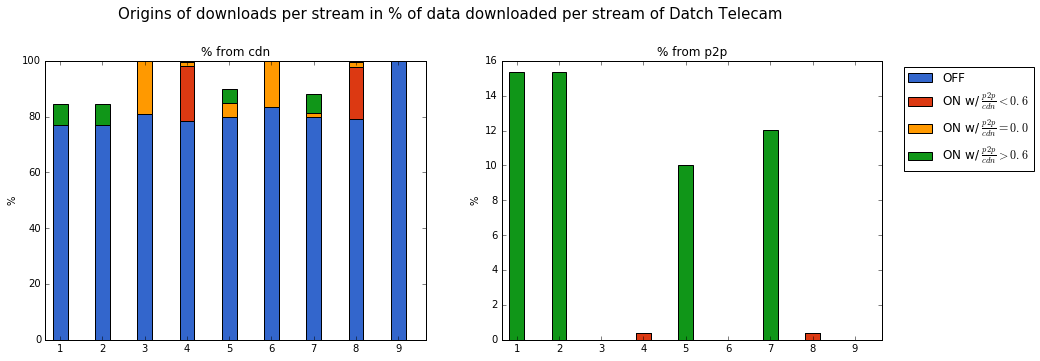

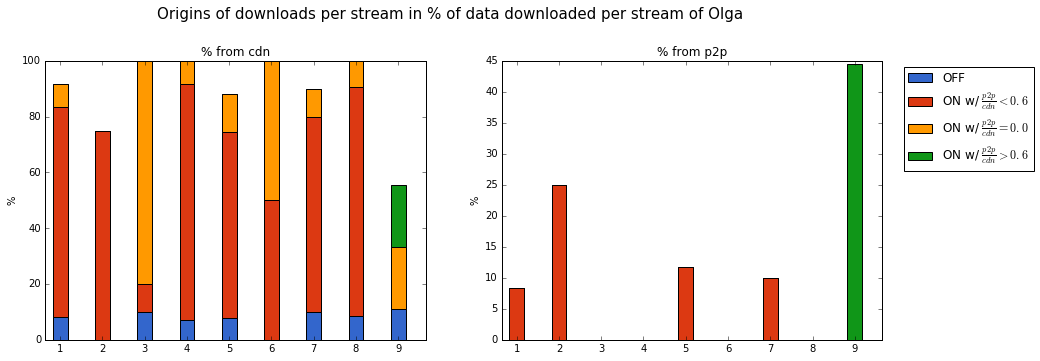

In [15]:
isp_name = 'Datch Telecam'
datch = make_dataframe(data, isp_name, index, 60)
title = 'Origins of downloads per stream in % of data downloaded per stream of {}'.format(isp_name)
make_p2p_cdn_plot(datch, isp_name, index, 'cdn_perc_ind', 'p2p_perc_ind', title)
isp_name = 'Olga'
olga = make_dataframe(data, isp_name, index, 60)
title = 'Origins of downloads per stream in % of data downloaded per stream of {}'.format(isp_name)
make_p2p_cdn_plot(olga, isp_name, index, 'cdn_perc_ind', 'p2p_perc_ind', title)

### COMMENTS
Datch Telecam:
- we can see another time the problem of connection for Datch Telecam: for each stream at least  80% of the data come from people that are OFF, stream 9 is 100% OFF.
- for stream 1 to 8, the remaining 20% of data have a distribution similar to what we saw with the previous ISP: streams 1,2,5 and 7 have at least 10% coming from p2p of people with good rate, streams 3 and 6 last 20% are exclusively from people with zero rate.

Olga:
- streams 1,2,5 and 7 have around 70% of their downloads coming from viewers with bad rates, just like the general problem with streams 4 and 8.
- streams 3 and 6 have also a similar distribution to what has already been said for Arange, BTP and Fro: respectively 80% and 50% of their downloads come from people with zero rate.

### CONCLUSION TO IMPROVE THE SERVICE
The general comments we can make to improve the service are:
- there is a problem of connection or sharing for **streams 3 and 6**: most people on these streams have a zero rate. They could actually be disconnected but they appear connected…
- in addition to the previous problem, **Olga seems to have a general problem of bad p2p/cdn rate**.
- For **Datch Telecam** we find the **same result as before, 80% of the downloads for each stream come from people OFF**, but the remaining 20% has a similar distribution as Arange, BTP and Fro, so if we solve the issue of connecting back the 80%, then we should have a similar situation to those ISPs.

## BROWSERS

Now we can check if any issue is related to the browser viewers used. First let’s check for how downloads are distributed over browsers for every ISP:

In [16]:
browser = data.copy()
browser = browser.groupby(['browser', 'isp']).sum()[['p2p', 'cdn']]
browser['percentage of total downloads'] = (browser['p2p'] + browser['cdn'])*100 / (browser['p2p'].sum(level=1)+browser['cdn'].sum(level=1))
del browser['p2p']
del browser['cdn']
browser.round(2)

percentage of total downloads
browser   isp                                         
EarthWolf Arange                                 60.49
          BTP                                    59.77
          Datch Telecam                          60.74
          Fro                                    59.89
          Olga                                   60.91
Iron      Arange                                 37.25
          BTP                                    37.85
          Datch Telecam                          36.61
          Fro                                    37.80
          Olga                                   36.70
Swamp     Arange                                  0.74
          BTP                                     0.75
          Datch Telecam                           0.70
          Fro                                     0.72
          Olga                                    0.96
Vectrice  Arange                                  1.52
          BTP                                     1.63
          Datch Telecam                           1.94
          Fro                                     1.58
          Olga                                    1.43

### COMMENTS
- we observe the same scheme for every ISP: 60% of the total amount of downloads come from EarthWolf users, 37% from Iron’s, 2% from Swamp and 1% from Vectrice.
- there is **no browser that is more represented for one particular ISP**, if this were true we could have prioritized working on a particular browser.

Now let’s make something similar to what we have done with the ISPs and the streams: we are going to break down the total of downloads for each browser into the four categories of users. We are going to add another categorization: whether the data is from stream 4 or 8, or not. As we have seen it before, those two streams are the post important for ISPs, we should find the same results with the browser and have a clearer view of what happens for the other streams.

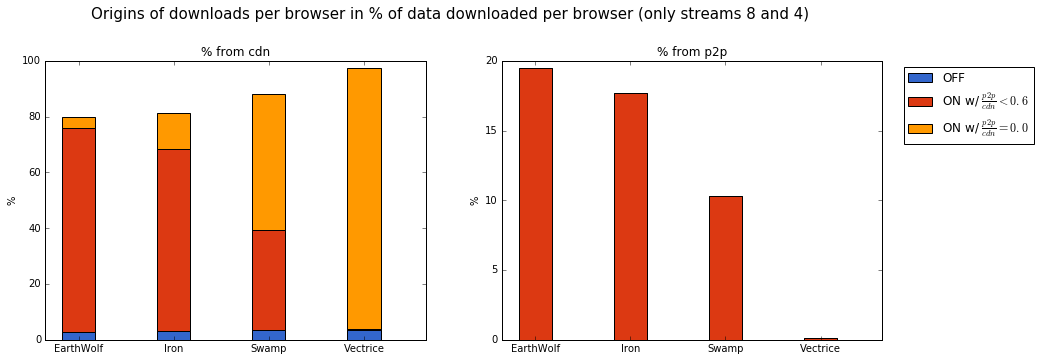

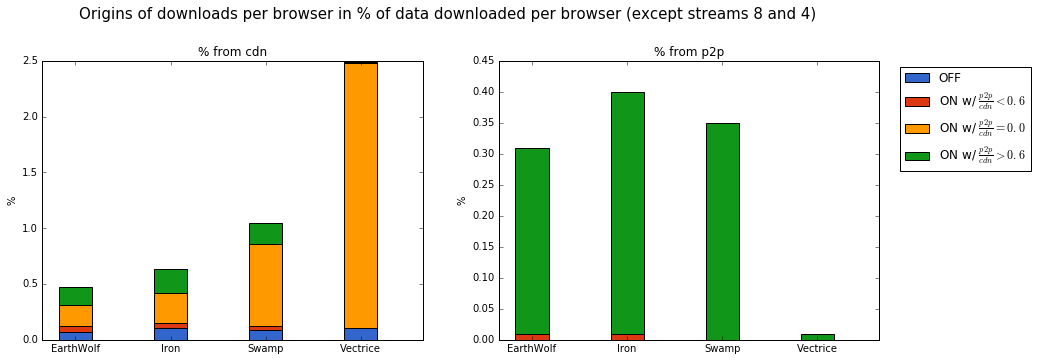

In [17]:
data_rate['is_4_or_8'] = (data_rate['stream'] == 4) | (data_rate['stream'] == 8)
df = (data_rate.groupby(['connected','good_rate','zero_rate', 'browser', 'is_4_or_8'])['p2p', 'cdn'].sum()/1e9).round(2)
df['p2p_perc'] = (df['p2p'] * 100 / (df['cdn'].sum(level=3)+df['p2p'].sum(level=3))).round(2)
df['cdn_perc'] = (df['cdn'] * 100 / (df['cdn'].sum(level=3)+df['p2p'].sum(level=3))).round(2)

big_streams = df.iloc[(df.index.get_level_values('is_4_or_8') == True)].reset_index(level=4, drop=True)
title = 'Origins of downloads per browser in % of data downloaded per browser (only streams 8 and 4)'
make_p2p_cdn_plot(big_streams, isp_name, index, 'cdn_perc', 'p2p_perc', title)

small_streams = df.iloc[(df.index.get_level_values('is_4_or_8') == False)].reset_index(level=4, drop=True)
title = 'Origins of downloads per browser in % of data downloaded per browser (except streams 8 and 4)'
make_p2p_cdn_plot(small_streams, isp_name, index, 'cdn_perc', 'p2p_perc', title)

Now let's focus on what happens for Vectrice and Swamps:

In [18]:
print('Vectrice')
display(df.iloc[df.index.get_level_values('browser') == 'Vectrice'].reset_index(level=3, drop=True))
print('Swamp')
display(df.iloc[df.index.get_level_values('browser') == 'Swamp'].reset_index(level=3, drop=True))

Vectrice


p2p     cdn  p2p_perc  cdn_perc
connected good_rate zero_rate is_4_or_8                                  
False     False     True      False      0.00    0.18      0.00      0.11
                              True       0.00    5.53      0.00      3.46
True      False     False     False      0.00    0.00      0.00      0.00
                              True       0.25    0.74      0.16      0.46
                    True      False      0.00    3.80      0.00      2.37
                              True       0.00  149.48      0.00     93.42
          True      False     False      0.02    0.01      0.01      0.01

Swamp


p2p    cdn  p2p_perc  cdn_perc
connected good_rate zero_rate is_4_or_8                                 
False     False     True      False      0.00   0.07      0.00      0.09
                              True       0.00   2.49      0.00      3.34
True      False     False     False      0.00   0.02      0.00      0.03
                              True       7.72  27.00     10.34     36.17
                    True      False      0.00   0.55      0.00      0.74
                              True       0.00  36.40      0.00     48.76
          True      False     False      0.26   0.14      0.35      0.19

### COMMENTS
- as expected, at least 80% of downloads for every browser is due to streams 4 and 8
- **Vectrice**: around 96% of downloads are from viewers with a zero rate, 93.5% from streams 8 and 4 and of the 2.5% that represent the other streams, 2.5 are from people with zero rate.
- **Swamps**: 50% of downloads are from viewers with a zero rate, we find the same distribution when focusing on streams 8 and 4 (50% of people with a zero rate) and streams that are not 4 and 8 (around 50% of the total is from people with zero rates)

### CONCLUSION TO IMPROVE THE SERVICE
- **Vectrice** has a problem of connection: almost 100% of its users have a zero rate
- **Swamp** seems to have a similar problem: half of its downloads are from users that have a zero rate.  

**We should first focus on solving the zero rate issue with Vectrice and then Swamp as respectively 100% and 50% of their downloads are concerned with the zero rate issue.**

## VIEWERS

A last thing we can check is the number of users per stream and per ISP. If ISPs prefer to focus on their customers' experience quality we can focus on improving the streams that are the most downloaded and not necessarily the most expensive in terms of Gbits. Maybe the ISPs do not want most of their customers to experience lags due to poor rate, or zero rate…

### Arange, BTP and Fro

Again we have a similar situation for Arange, BTP and Fro: their numbers of customers per stream is quite evenly distributed in comparaison to Datch Telecam and Olga.

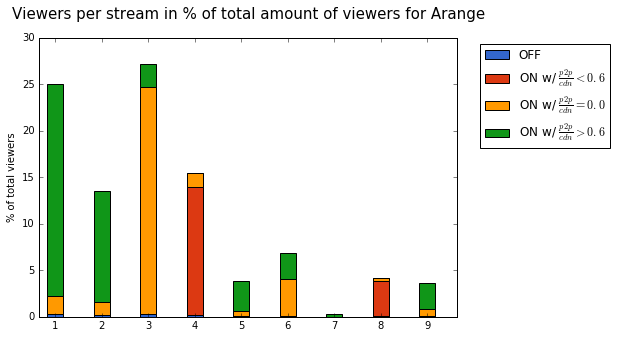

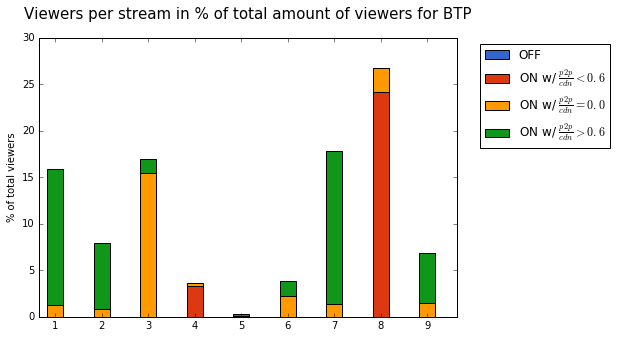

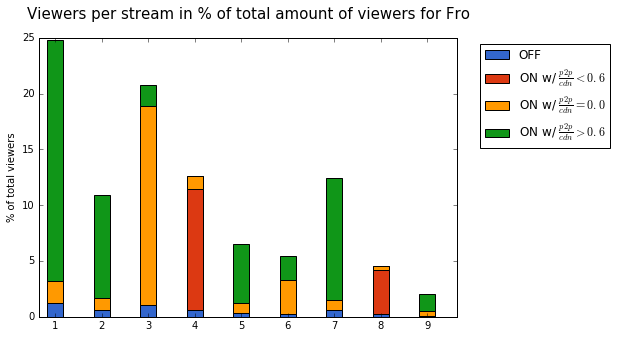

In [19]:
stacks_names = [r'OFF', r'ON w/ $\frac{p2p}{cdn} < 0.6$',
                    r'ON w/ $\frac{p2p}{cdn} = 0.0$', r'ON w/ $\frac{p2p}{cdn} > 0.6$']

isp_name = 'Arange'
arange = make_dataframe(data, isp_name, index, 60)
title = 'Viewers per stream in % of total amount of viewers for {}'.format(isp_name)
bar_stack(make_stack_list(arange, 'viewer_perc'), data.stream.unique(), stacks_names, title, '% of total viewers')

isp_name = 'BTP'
btp = make_dataframe(data, isp_name, index, 60)
title = 'Viewers per stream in % of total amount of viewers for {}'.format(isp_name)
bar_stack(make_stack_list(btp, 'viewer_perc'), data.stream.unique(), stacks_names, title, '% of total viewers')

isp_name = 'Fro'
fro = make_dataframe(data, isp_name, index, 60)
title = 'Viewers per stream in % of total amount of viewers for {}'.format(isp_name)
bar_stack(make_stack_list(fro, 'viewer_perc'), data.stream.unique(), stacks_names, title, '% of total viewers')

### CONCLUSION TO IMPROVE THE SERVICE
So for the first three we can recommend to focus on the most important streams in terms of customers where a lot of customers are more likely to be experiencing lags:
- Arange: 
    - stream 3 (27% of total customers) where 25% customers have a zero rate
    - stream 4 (15% of total customers) where around 14% have a bad rate
- BTP:
    - stream 8 (27% of total customers) where around 25% customers have a bad rate
    - stream 3 (17% of total customers) where around 15% have a zero rate
- Fro:
    - stream 3 (22% of total customers) where 18% customers have a zero rate
    - stream 4 (12% of total customers) where around 11% have a bad rate

### Datch Telecam and Olga

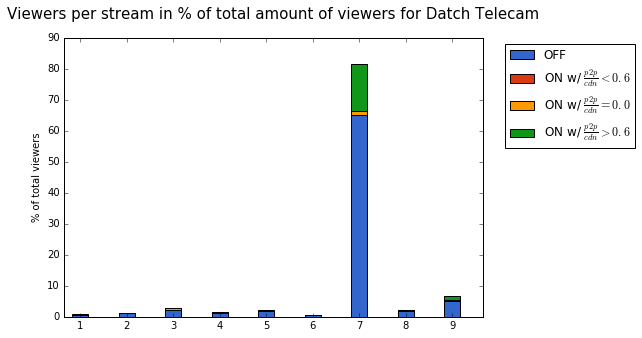

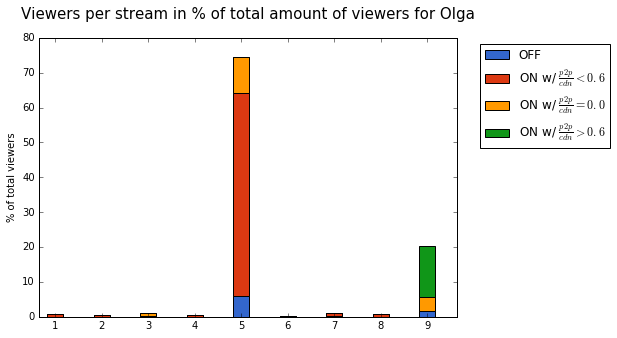

In [20]:
isp_name = 'Datch Telecam'
datch = make_dataframe(data, isp_name, index, 60)
title = 'Viewers per stream in % of total amount of viewers for {}'.format(isp_name)
bar_stack(make_stack_list(datch, 'viewer_perc'), data.stream.unique(), stacks_names, title, '% of total viewers')

isp_name = 'Olga'
olga = make_dataframe(data, isp_name, index, 60)
title = 'Viewers per stream in % of total amount of viewers for {}'.format(isp_name)
bar_stack(make_stack_list(olga, 'viewer_perc'), data.stream.unique(), stacks_names, title, '% of total viewers')

### CONCLUSION TO IMPROVE THE SERVICE
We can see that Datch Telecam and Olga customers are watching one stream in particular (stream 7 for Datch Telecam and 5 for Olga).
- Datch Telecam :
    - stream 7 represents 80% of Datch Telecam customers and 75% of them are OFF
- Olga:
    - stream 5 represents 75% of Olga customers where 60% customers have a bad rate, 10% have a zero rate and 5% are OFF.